In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import matplotlib.pyplot as plot

# we can use the LabelEncoder to encode the gender feature
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, cross_validate

# importing two different imputation methods that take into consideration all the features when predicting the missing values
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#heatmap
import seaborn as sns

#multiclass imports
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier #Will identify the maority calss base line, model needs to do better then the baseline

# oversample the minority class using SMOTE
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

from statistics import mean
# to reduce randomness then you put the seed
np.random.seed(42)

In [2]:
#Read the csv file containing all data
df = pd.read_csv("./data/student_prediction.csv")

#There is a column name error in the data noted in the Kaggle description, this fixes it.
df = df.rename(columns = {'KIDS':'PARENT_STATUS'}) 
df = df.drop(["STUDENTID", "COURSE ID"], axis=1)

#Load the survey data
gathered_df = pd.read_csv("./data/Higher Education Students Performance Evaluation.csv")

#There is a column name error in the data noted in the Kaggle description, this fixes it.
gathered_df = gathered_df.rename(columns = {'KIDS':'PARENT_STATUS'})

#Print the dataframe shape
print(f"Data shape: \n{df.shape}\n")
print(f"Data size: \n{df.size}\n")
print(f"Data ndim: \n{df.ndim}\n")
print("_____________________________________________\n")



Data shape: 
(145, 31)

Data size: 
4495

Data ndim: 
2

_____________________________________________



<AxesSubplot:xlabel='GENDER', ylabel='GRADE'>

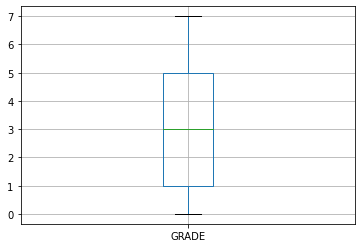

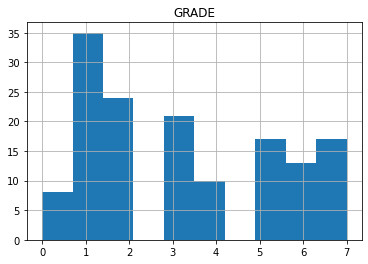

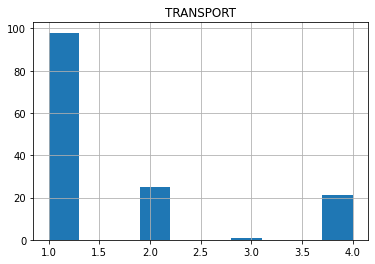

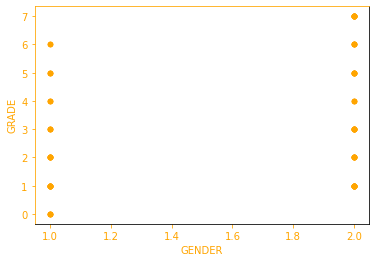

In [3]:

#Here we observe the data in the dataframe
boxplot = df.boxplot(column = 'GRADE')
histogram = df.hist(column = 'GRADE')
histogram = df.hist(column = 'TRANSPORT')
scatterPlot = df.plot.scatter(x='GENDER', y='GRADE', c='orange')
scatterPlot.xaxis.label.set_color('orange')        #setting up X-axis label color to orange
scatterPlot.yaxis.label.set_color('orange')          #setting up Y-axis label color to orange
scatterPlot.tick_params(axis='x', colors='orange')    #setting up X-axis tick color to orange
scatterPlot.tick_params(axis='y', colors='orange')  #setting up Y-axis tick color to orange
scatterPlot.spines['left'].set_color('orange')        # setting up Y-axis tick color to orange
scatterPlot.spines['top'].set_color('orange')         #setting up above X-axis tick color to orange
scatterPlot


In [4]:
#Create an oversampling object
oversample = SMOTE()
#Oversample and add to the dataframe to fix the class imbalance
x_over, y_over = oversample.fit_resample(df.drop(["GRADE"], axis=1), df.drop(df.columns[0:-1],axis=1))
df = pd.concat([x_over, y_over], axis=1)

# print the dimensionality of the oversampled dataset
print(f"Oversampled Data shape: \n{df.shape}\n")
print(f"Oversampled Data size: \n{df.size}\n")
print(f"Oversampled Data ndim: \n{df.ndim}\n")
print("_____________________________________________\n")


# print the new class distribution using a Counter
print(f"New Class Distribution: {Counter(df['GRADE'])}")
print("_____________________________________________\n")

Oversampled Data shape: 
(280, 31)

Oversampled Data size: 
8680

Oversampled Data ndim: 
2

_____________________________________________

New Class Distribution: Counter({1: 35, 2: 35, 5: 35, 0: 35, 3: 35, 4: 35, 7: 35, 6: 35})
_____________________________________________



<AxesSubplot:xlabel='GENDER', ylabel='GRADE'>

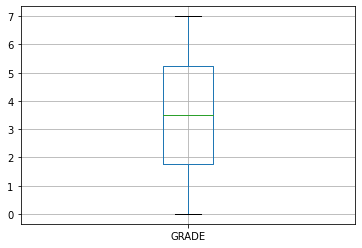

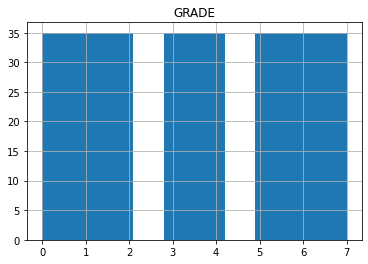

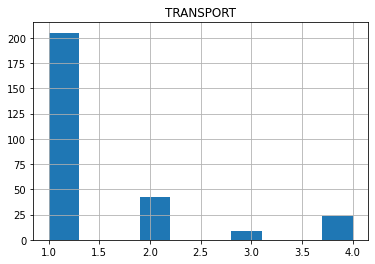

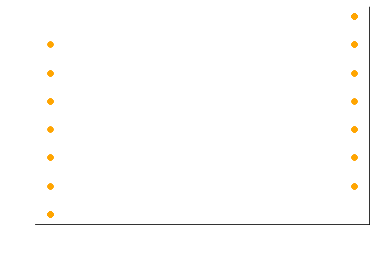

In [5]:
#how oversampling changes our data
boxplot = df.boxplot(column = 'GRADE')
histogram = df.hist(column = 'GRADE')
histogram = df.hist(column = 'TRANSPORT')
scatterPlot = df.plot.scatter(x='GENDER', y='GRADE', c='orange')
scatterPlot.xaxis.label.set_color('orange')        #setting up X-axis label color to orange
scatterPlot.yaxis.label.set_color('orange')          #setting up Y-axis label color to orange
scatterPlot.tick_params(axis='x', colors='orange')    #setting up X-axis tick color to orange
scatterPlot.tick_params(axis='y', colors='orange')  #setting up Y-axis tick color to orange
scatterPlot.spines['left'].set_color('orange')        # setting up Y-axis tick color to orange
scatterPlot.spines['top'].set_color('orange')         #setting up above X-axis tick color to orange
scatterPlot

In [6]:
#Split the dataset into a train set = 80% and test = 20%
data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)

#Print the shape of the train and test set
print(f"Train Data shape: \n{data_train}\n")
print(f"Test Data shape: \n{data_test}\n")

Train Data shape: 
     AGE  GENDER  HS_TYPE  SCHOLARSHIP  WORK  ACTIVITY  PARTNER  SALARY  \
86     2       2        2            4     2         2        2       1   
137    1       1        1            5     2         1        2       1   
184    2       2        2            4     1         2        2       1   
5      2       2        2            3     2         2        2       2   
124    1       1        2            4     1         1        1       1   
..   ...     ...      ...          ...   ...       ...      ...     ...   
188    1       2        2            3     1         2        1       4   
71     1       1        3            4     2         2        2       1   
106    1       2        2            4     2         1        2       1   
270    1       2        2            4     2         1        1       1   
102    1       2        2            3     2         2        1       1   

     TRANSPORT  LIVING  ...  ATTEND  PREP_STUDY  PREP_EXAM  NOTES  LISTENS  \
86

In [7]:
#Print the dataset
df

,AGE,GENDER,HS_TYPE,SCHOLARSHIP,WORK,ACTIVITY,PARTNER,SALARY,TRANSPORT,LIVING,...,ATTEND,PREP_STUDY,PREP_EXAM,NOTES,LISTENS,LIKES_DISCUSS,CLASSROOM,CUML_GPA,EXP_GPA,GRADE
0,2,2,3,3,1,2,2,1,1,1,...,1,1,1,3,2,1,2,1,1,1
1,2,2,3,3,1,2,2,1,1,1,...,1,1,1,3,2,3,2,2,3,1
2,2,2,2,3,2,2,2,2,4,2,...,1,1,1,2,2,1,1,2,2,1
3,1,1,1,3,1,2,1,2,1,2,...,1,1,2,3,2,2,1,3,2,1
4,2,2,1,3,2,2,1,3,1,4,...,1,2,1,2,2,2,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,1,2,2,4,1,2,1,1,1,1,...,1,1,1,3,2,2,2,3,3,7
276,1,2,2,4,2,1,1,1,1,2,...,1,1,1,3,2,2,1,2,3,7
277,1,2,1,2,2,2,1,2,1,2,...,1,2,1,2,2,2,1,1,1,7
278,1,2,2,4,2,1,1,1,1,1,...,1,1,1,3,2,3,2,2,3,7


In [8]:
#Extracting Labels
#Get a list of all columns
columns = data_train.columns.to_list()
#Remove the label and save it
columns_drop = columns.pop(-1)

#Remove all labels except for the label in the train and test dataframe
labels_train = data_train.drop(columns, axis=1)
labels_test = data_test.drop(columns, axis=1)

#Print the labesl of the test and train
print(f"labels_train: \n{labels_train}\n")
print(f"labels_test: \n{labels_test}\n")

#Remove the label from the train and test dataframe
features_train = data_train.drop(['GRADE'], axis=1)
features_test = data_test.drop(['GRADE'], axis=1)

#Print the features of the train and test dataset
print(f"features_train: \n{features_train }\n")
print(f"lfeatures_test: \n{features_test }\n")



labels_train: 
     GRADE
86       5
137      2
184      3
5        2
124      3
..     ...
188      3
71       6
106      7
270      7
102      7

[224 rows x 1 columns]

labels_test: 
     GRADE
33       2
108      6
240      6
259      6
154      0
9        0
146      0
203      4
144      3
155      0
221      4
92       7
222      5
209      4
42       1
210      4
66       5
90       6
119      2
142      1
262      7
268      7
206      4
238      5
46       5
77       7
68       5
75       7
216      4
277      7
45       3
111      2
60       2
217      4
143      4
30       5
22       3
24       2
127      1
176      2
79       3
264      7
237      5
120      1
196      3
245      6
168      0
6        5
239      5
73       6
84       7
56       5
25       3
97       6
147      0
19       3

features_train: 
     AGE  GENDER  HS_TYPE  SCHOLARSHIP  WORK  ACTIVITY  PARTNER  SALARY  \
86     2       2        2            4     2         2        2       1   
137    1       1   

In [9]:

#Create a One Hot encoder object
ohenc = OneHotEncoder(sparse=False)

#Fit the One Hot encoder to all features that are nominal
ohenc_cols = ohenc.fit(features_train.drop(['AGE', 'SCHOLARSHIP', 'SALARY', 'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'STUDY_HRS', 
                'READ_FREQ', 'READ_FREQ_SCI', 'IMPACT', 'ATTEND', 'NOTES', 'LISTENS', 'LIKES_DISCUSS',
                'CUML_GPA', 'EXP_GPA'], axis=1)).get_feature_names_out()

#List of the features which are ordinal
ord_attribs = ['AGE', 'SCHOLARSHIP', 'SALARY', 'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'STUDY_HRS', 
                'READ_FREQ', 'READ_FREQ_SCI', 'IMPACT', 'ATTEND', 'NOTES', 'LISTENS', 'LIKES_DISCUSS',
                'CUML_GPA', 'EXP_GPA']

#List of the features which are nominal
nom_attribs = ['GENDER', 'HS_TYPE', 'WORK', 'ACTIVITY', 'PARTNER', 'TRANSPORT', 'LIVING', 'PARENT_STATUS',
                'MOTHER_JOB', 'FATHER_JOB', 'ATTEND_DEPT', 'PREP_STUDY', 'PREP_EXAM', 'CLASSROOM']

#List all features which are added by the onehot encoder plus the ordinal features
pipe_cols = ['AGE' ,'GENDER_1' ,'GENDER_2' ,'HS_TYPE_1' ,'HS_TYPE_2' ,'HS_TYPE_3', 'SCHOLARSHIP' ,'WORK_1',
             'WORK_2' ,'ACTIVITY_1', 'ACTIVITY_2', 'PARTNER_1' ,'PARTNER_2' ,'SALARY', 'TRANSPORT_1',
             'TRANSPORT_2', 'TRANSPORT_3' ,'TRANSPORT_4' ,'LIVING_1' ,'LIVING_2', 'LIVING_3', 'LIVING_4',
             'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'PARENT_STATUS_1' ,'PARENT_STATUS_2', 'PARENT_STATUS_3',
             'MOTHER_JOB_1' ,'MOTHER_JOB_2' ,'MOTHER_JOB_3', 'MOTHER_JOB_4' ,'MOTHER_JOB_5' ,'FATHER_JOB_1' , 
             'FATHER_JOB_2', 'FATHER_JOB_3' ,'FATHER_JOB_4' ,'FATHER_JOB_5', 'STUDY_HRS', 'READ_FREQ',
             'READ_FREQ_SCI',  'ATTEND_DEPT_1', 'ATTEND_DEPT_2', 'IMPACT', 'ATTEND','PREP_STUDY_1' ,'PREP_STUDY_2', 
             'PREP_STUDY_3', 'PREP_EXAM_1', 'PREP_EXAM_2' ,'PREP_EXAM_3' ,'NOTES', 'LISTENS', 'LIKES_DISCUSS', 
             'CLASSROOM_1' ,'CLASSROOM_2', 'CLASSROOM_3','CUML_GPA', 'EXP_GPA']

#Preform the encoding in a pipeline
full_pipeline = ColumnTransformer([
        ("Nominal", OneHotEncoder(), nom_attribs),
        ("Ordinal", OrdinalEncoder(), ord_attribs)
    ])

#Fit and transform the data from the pipeline
data_prepared = pd.DataFrame(full_pipeline.fit_transform(features_train),columns=pipe_cols, index=features_train.index)

zero_data = np.zeros(shape=(len(data_prepared),1))




In [10]:

labelTrainFlat = labels_train.values.ravel()

#Fit one vs rest Gradient Boosting classification
gradientBoosting = OneVsRestClassifier(GradientBoostingClassifier())
gradientBoosting = gradientBoosting.fit(data_prepared, labelTrainFlat)

#Fit DecisionTreeClassifier classification
decisionTree = DecisionTreeClassifier()
decisionTree = decisionTree.fit(data_prepared,labelTrainFlat)

#Fit RandomForestClassifier classification
randomForest = RandomForestClassifier()
randomForest = randomForest.fit(data_prepared,labelTrainFlat)

In [11]:
#Set the parameters of GradientBoosting for GridSearchCV
parametersGradientBoosting = [
    {'estimator__learning_rate': [0.44,0.45,0.46],'estimator__min_samples_leaf': [5,6,7],'estimator__min_samples_split': [7,8,9,10], 'estimator__n_estimators': [57,58,59,60]}
]

#Set the scoring parameters
scoringX = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}

#Preform Gridsearch to find best parameters
grid_searchGradientBoosting = GridSearchCV(gradientBoosting, parametersGradientBoosting, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

#Fit the GradientBoosting 
grid_searchGradientBoosting.fit(data_prepared, labelTrainFlat)

#Print GridSearchCV Results
print(f"Best parameters GradientBoosting: \n{grid_searchGradientBoosting.best_params_}\n")
print(f"Best estimator GradientBoosting: \n{grid_searchGradientBoosting.best_estimator_}\n")
print(f"Best score GradientBoosting: \n{grid_searchGradientBoosting.best_score_}\n")

KeyboardInterrupt: 

In [ ]:

#Create a KNeighbors classification object
kNeighbors = KNeighborsClassifier()
kNeighbors = kNeighbors.fit(data_prepared,labelTrainFlat)

#Set the parameters of KNeighbors for GridSearchCV
parametersKNeighbors = [
    {'n_neighbors': [1,2,3],'weights':['uniform', 'distance'],'algorithm':['auto'], 'p': [1,2,3]}
]

#Set the scoring parameters
scoringX = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}

#Preform KNeighbors to find best parameters
grid_searchKNeighbors = GridSearchCV(kNeighbors, parametersKNeighbors, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

#Fit the KNeighbors 
grid_searchKNeighbors.fit(data_prepared, labelTrainFlat)

#Print GridSearchCV Results
print(f"Best parameters KNeighbors: \n{grid_searchKNeighbors.best_params_}\n")
print(f"Best estimator KNeighbors: \n{grid_searchKNeighbors.best_estimator_}\n")
print(f"Best score KNeighbors: \n{grid_searchKNeighbors.best_score_}\n")

Best parameters KNeighbors: 
{'algorithm': 'auto', 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

Best estimator KNeighbors: 
KNeighborsClassifier(n_neighbors=2, weights='distance')

Best score KNeighbors: 
0.6709701178451177



In [ ]:
#Create an LogisticRegression object
logisticRegression = LogisticRegression(max_iter=5000)
logisticRegression = logisticRegression.fit(data_prepared,labelTrainFlat)

#Set the parameters of LogisticRegression for GridSearchCV
parametersLogisticRegression = [
    {'multi_class': ['ovr'],'penalty':['none','l2'], 'C': [1,2,3]}
]
scoringX = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}

#Preform LogisticRegression to find best parameters
grid_searchLogisticRegression = GridSearchCV(logisticRegression, parametersLogisticRegression, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

#Fit the LogisticRegression 
grid_searchLogisticRegression.fit(data_prepared, labelTrainFlat)

#Print LogisticRegression Results
print(f"Best parameters Logistic Regression: \n{grid_searchLogisticRegression.best_params_}\n")
print(f"Best estimator Logistic Regression: \n{grid_searchLogisticRegression.best_estimator_}\n")
print(f"Best score Logistic Regression: \n{grid_searchLogisticRegression.best_score_}\n")

Best parameters Logistic Regression: 
{'C': 2, 'multi_class': 'ovr', 'penalty': 'l2'}

Best estimator Logistic Regression: 
LogisticRegression(C=2, max_iter=5000, multi_class='ovr')

Best score Logistic Regression: 
0.5035563973063972



In [ ]:
#Set the parameters of DecisionTree for GridSearchCV
parametersDecisionTree = [
    {'max_depth': [1,2,3,4], 'min_samples_leaf': [4,5,6], 'min_samples_split': [2,3]}
]

#Preform Gridsearch to find best parameters
grid_searchDecisionTree = GridSearchCV(decisionTree, parametersDecisionTree, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

#Fit the DecisionTree 
grid_searchDecisionTree.fit(data_prepared, labelTrainFlat)

#Print GridSearchCV Results
print(f"Best parameters DecisionTree: \n{grid_searchDecisionTree.best_params_}\n")
print(f"Best estimator DecisionTree: \n{grid_searchDecisionTree.best_estimator_}\n")
print(f"Best score DecisionTree: \n{grid_searchDecisionTree.best_score_}\n")

Best parameters DecisionTree: 
{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}

Best estimator DecisionTree: 
DecisionTreeClassifier(max_depth=4, min_samples_leaf=4)

Best score DecisionTree: 
0.33188131313131314



In [ ]:
#Set the parameters of RandomForest for GridSearchCV
parametersRandomForest = [
    {'n_estimators': [145,150,155,190],'max_depth': [10,12], 'bootstrap': [True, False],
     'min_samples_split': [0.05,2], 'max_features': ['auto']}
]

#Preform Gridsearch to find best parameters
grid_searchRandomForest = GridSearchCV(randomForest, parametersRandomForest, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

#Fit the RandomForest 
grid_searchRandomForest.fit(data_prepared, labelTrainFlat)

#Print GridSearchCV Results
print(f"Best parameters RandomForest: \n{grid_searchRandomForest.best_params_}\n")
print(f"Best estimator RandomForest: \n{grid_searchRandomForest.best_estimator_}\n")
print(f"Best score RandomForest: \n{grid_searchRandomForest.best_score_}\n")

Best parameters RandomForest: 
{'bootstrap': False, 'max_depth': 12, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 190}

Best estimator RandomForest: 
RandomForestClassifier(bootstrap=False, max_depth=12, n_estimators=190)

Best score RandomForest: 
0.6804315476190476



In [ ]:
#Get the results for all classifiers 
cross_val_resultsGB = grid_searchGradientBoosting.cv_results_
cross_val_resultsDT = grid_searchDecisionTree.cv_results_
cross_val_resultsRF = grid_searchRandomForest.cv_results_
cross_val_resultsLR = grid_searchLogisticRegression.cv_results_
cross_val_resultsKN = grid_searchKNeighbors.cv_results_


#Print the results of all classiifiers
#GBC
print(f"Mean Test Accuracy for Gradient Boosting: \n{mean(cross_val_resultsGB['mean_test_accuracy'])}\n")
print(f"Balanced Test Accuracy for Gradient Boosting: \n{mean(cross_val_resultsGB['mean_test_bal_accuracy'])}\n")
print(f"Mean F1 Macro for Gradient Boosting: \n{mean(cross_val_resultsGB['mean_test_F1_macro'])}\n")

#DTC
print(f"Mean Test Accuracy for Decision Trees: \n{mean(cross_val_resultsDT['mean_test_accuracy'])}\n")
print(f"Balanced Test Accuracy for Decision Trees: \n{mean(cross_val_resultsDT['mean_test_bal_accuracy'])}\n")
print(f"Mean F1 Macro for Decision Trees: \n{mean(cross_val_resultsDT['mean_test_F1_macro'])}\n")

#RFC
print(f"Mean Test Accuracy for Random Forests: \n{mean(cross_val_resultsRF['mean_test_accuracy'])}\n")
print(f"Balanced Test Accuracy for Random Forests: \n{mean(cross_val_resultsRF['mean_test_bal_accuracy'])}\n")
print(f"Mean F1 Macro for Random Forests: \n{mean(cross_val_resultsRF['mean_test_F1_macro'])}\n")

#LRC
print(f"Mean Test Accuracy for Logistic Regression: \n{mean(cross_val_resultsLR['mean_test_accuracy'])}\n")
print(f"Balanced Test Accuracy for Logistic Regression: \n{mean(cross_val_resultsLR['mean_test_bal_accuracy'])}\n")
print(f"Mean F1 Macro for Logistic Regression: \n{mean(cross_val_resultsLR['mean_test_F1_macro'])}\n")

#KNC
print(f"Mean Test Accuracy for K Nearest Neighbours: \n{mean(cross_val_resultsKN['mean_test_accuracy'])}\n")
print(f"Balanced Test Accuracy for K Nearest Neighbours: \n{mean(cross_val_resultsKN['mean_test_bal_accuracy'])}\n")
print(f"Mean F1 Macro for Logistic K Nearest Neighbours: \n{mean(cross_val_resultsKN['mean_test_F1_macro'])}\n")


Mean Test Accuracy for Gradient Boosting: 
0.6493985615079365

Balanced Test Accuracy for Gradient Boosting: 
0.6515196139219577

Mean F1 Macro for Gradient Boosting: 
0.6475413616365144

Mean Test Accuracy for Decision Trees: 
0.23874874874874877

Balanced Test Accuracy for Decision Trees: 
0.23491336980920313

Mean F1 Macro for Decision Trees: 
0.17641883419833299

Mean Test Accuracy for Random Forests: 
0.6220703125

Balanced Test Accuracy for Random Forests: 
0.6283249627976191

Mean F1 Macro for Random Forests: 
0.613608556254708

Mean Test Accuracy for Logistic Regression: 
0.4820620620620621

Balanced Test Accuracy for Logistic Regression: 
0.48621808361391694

Mean F1 Macro for Logistic Regression: 
0.4794903795506445

Mean Test Accuracy for K Nearest Neighbours: 
0.6225492158825492

Balanced Test Accuracy for K Nearest Neighbours: 
0.6283547278338945

Mean F1 Macro for Logistic K Nearest Neighbours: 
0.6128118395919365



In [ ]:
#Create a dummy classifier to identify a simple baseline
dummy_clf = DummyClassifier(strategy="uniform", random_state=35)
dummy_clf.fit(data_prepared, labelTrainFlat)
print(f"Dummy Prediction: \n{dummy_clf.predict(data_prepared)}\n") 
print(f"Dummy Score: \n{dummy_clf.score(data_prepared, labelTrainFlat)}\n") 

Dummy Prediction: 
[1 7 4 7 1 4 7 0 1 0 3 3 0 0 1 7 6 4 6 3 7 0 0 1 4 5 2 7 5 3 3 3 1 5 3 0 7
 5 0 6 0 5 6 4 4 1 1 6 2 1 6 0 2 2 2 5 0 3 7 6 0 2 5 4 1 3 5 6 2 4 4 7 6 2
 3 1 5 4 3 4 4 2 7 2 3 4 5 4 2 5 7 4 7 5 1 4 7 6 4 5 0 2 0 7 6 6 7 6 3 4 6
 4 0 4 5 5 4 5 4 7 4 2 0 3 4 5 1 5 4 2 2 3 4 3 7 5 6 1 7 7 4 3 7 0 0 3 5 6
 6 2 3 3 1 2 0 5 1 3 1 7 6 3 2 6 2 2 2 3 6 7 0 5 7 4 3 7 2 5 0 7 7 5 0 2 0
 6 0 4 0 0 6 4 0 7 5 7 3 2 0 3 7 7 0 0 6 3 2 3 5 5 4 5 4 6 6 5 5 3 5 3 0 5
 1 2]

Dummy Score: 
0.12946428571428573



              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.00      0.00      0.00         4
           2       0.75      0.50      0.60         6
           3       0.83      0.71      0.77         7
           4       0.73      1.00      0.84         8
           5       0.55      0.60      0.57        10
           6       0.50      0.57      0.53         7
           7       1.00      0.62      0.77         8

    accuracy                           0.66        56
   macro avg       0.63      0.63      0.61        56
weighted avg       0.66      0.66      0.65        56

[[6 0 0 0 0 0 0 0]
 [3 0 1 0 0 0 0 0]
 [0 1 3 0 0 2 0 0]
 [0 1 0 5 0 1 0 0]
 [0 0 0 0 8 0 0 0]
 [0 0 0 1 0 6 3 0]
 [0 0 0 0 1 2 4 0]
 [0 0 0 0 2 0 1 5]]


<AxesSubplot:>

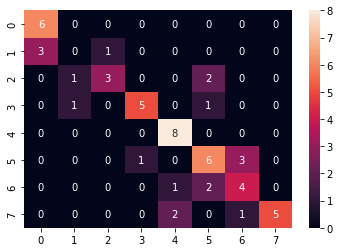

In [ ]:

#Create a One Hot encoder object
ohenc_test = OneHotEncoder(sparse=False)

#Fit the One Hot encoder to all features that are nominal
ohenc_cols_test = ohenc.fit(features_test.drop(['AGE', 'SCHOLARSHIP', 'SALARY', 'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'STUDY_HRS', 
                'READ_FREQ', 'READ_FREQ_SCI', 'IMPACT', 'ATTEND', 'NOTES', 'LISTENS', 'LIKES_DISCUSS',
                'CUML_GPA', 'EXP_GPA'], axis=1)).get_feature_names_out()

#Add the coloumns that are missed when onehot encoding. There is no values for these in our test and train
missing_cols_from_test = ['MOTHER_JOB_5', 'LIVING_4', 'FATHER_EDU_6']
missing_cols_from_train = ['MOTHER_EDU_6']

ord_attribs_test = ['AGE', 'SCHOLARSHIP', 'SALARY', 'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'STUDY_HRS', 
                'READ_FREQ', 'READ_FREQ_SCI', 'IMPACT', 'ATTEND', 'NOTES', 'LISTENS', 'LIKES_DISCUSS',
                'CUML_GPA', 'EXP_GPA']
nom_attribs_test = ['GENDER', 'HS_TYPE', 'WORK', 'ACTIVITY', 'PARTNER', 'TRANSPORT', 'LIVING', 'PARENT_STATUS',
                'MOTHER_JOB', 'FATHER_JOB', 'ATTEND_DEPT', 'PREP_STUDY', 'PREP_EXAM', 'CLASSROOM']

pipe_cols_test = ['AGE' ,'GENDER_1' ,'GENDER_2' ,'HS_TYPE_1' ,'HS_TYPE_2' ,'HS_TYPE_3', 'SCHOLARSHIP' ,'WORK_1',
             'WORK_2' ,'ACTIVITY_1', 'ACTIVITY_2', 'PARTNER_1' ,'PARTNER_2' ,'SALARY', 'TRANSPORT_1',
             'TRANSPORT_2', 'TRANSPORT_3' ,'TRANSPORT_4' ,'LIVING_1' ,'LIVING_2', 'LIVING_3',
             'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'PARENT_STATUS_1' ,'PARENT_STATUS_2', 'PARENT_STATUS_3',
             'MOTHER_JOB_1' ,'MOTHER_JOB_2' ,'MOTHER_JOB_3', 'MOTHER_JOB_4' ,'FATHER_JOB_1' , 
             'FATHER_JOB_2', 'FATHER_JOB_3' ,'FATHER_JOB_4' ,'FATHER_JOB_5', 'STUDY_HRS', 'READ_FREQ',
             'READ_FREQ_SCI',  'ATTEND_DEPT_1', 'ATTEND_DEPT_2', 'IMPACT', 'ATTEND','PREP_STUDY_1' ,'PREP_STUDY_2', 
             'PREP_STUDY_3', 'PREP_EXAM_1', 'PREP_EXAM_2' ,'PREP_EXAM_3' ,'NOTES', 'LISTENS', 'LIKES_DISCUSS', 
             'CLASSROOM_1' ,'CLASSROOM_2', 'CLASSROOM_3','CUML_GPA', 'EXP_GPA']


full_pipeline_test = ColumnTransformer([
        ("Nominal", OneHotEncoder(), nom_attribs),
        ("Ordinal", OrdinalEncoder(), ord_attribs)
    ])



data_prepared_test = pd.DataFrame(full_pipeline_test.fit_transform(features_test),columns=pipe_cols_test, index=features_test.index)
missing_cols_df = pd.DataFrame(0, index=np.arange(56), columns=missing_cols_from_test)
res = list(set(ohenc_cols).difference(set(ohenc_cols_test)))

zero_data = np.zeros(shape=(len(data_prepared_test),1))


data_prepared_test.insert(31,"MOTHER_JOB_5", zero_data) #Inserting those columns that are not represented in the test data
data_prepared_test.insert(21,"LIVING_4", zero_data)

#data_prepared_test.insert(43,"FATHER_EDU_6", zero_data)



# obtain predictions on test data using the best model from GridSearchCV (i.e., .best_estimator_) (2)
predictions_test = grid_searchKNeighbors.best_estimator_.predict(data_prepared_test)

# generate the classification report and the confusion matrix for test predictions (3)
print(classification_report(labels_test.values.ravel(),predictions_test))
print(confusion_matrix(labels_test, predictions_test))
sns.heatmap(confusion_matrix(labels_test, predictions_test), annot=True)


xnew = np.array([2,2,2,3,1,2,2,2,1,4,3,3,3,1,2,6,1,5,1,1,2,1,2,1,2,3,3,2,3,5,5])

data_prepared_test = pd.DataFrame(full_pipeline_test.fit_transform(xnew),columns=pipe_cols_test, index=features_test.index)
missing_cols_df = pd.DataFrame(0, index=np.arange(56), columns=missing_cols_from_test)
res = list(set(ohenc_cols).difference(set(ohenc_cols_test)))

zero_data = np.zeros(shape=(len(data_prepared_test),1))


data_prepared_test.insert(31,"MOTHER_JOB_5", zero_data) #Inserting those columns that are not represented in the test data
data_prepared_test.insert(21,"LIVING_4", zero_data)


ynew = grid_searchRandomForest.best_estimator_.predict(data_prepared_test)